# CAB420, Week 2 Practical Solutions
Note, as the three questions in this weeks practical build on one another, all solutions are in the one script

Updated (Ethan 15/03/21) - Corrected error in running final predictions with regularisation coefficient.
Updated Again (SD 17/03/21) - Reconciled earlier changes to remove redundant add_constants()

In [1]:
# import all the important packages
%matplotlib inline

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

## Preliminaries and Data Setup

We start with the same data preprocessing as last week to load the data, and clean it up. We'll load the combined file that we built then.

In [2]:
# loading in the combined data from the previous prac
combined = pd.read_csv('combined.csv')
# make sure the Date column is interpreted correctly as a datetime object
combined.Date = pd.to_datetime(combined.Date)
combined.head()

,Date,BicenntenialBikeway,BicentennialBikewayPedestriansInbound,BicentennialBikewayPedestriansOutbound,BicentennialBikewayCyclistsInbound,BicentennialBikewayCyclistsOutbound,BishopStreetPedestriansInbound,BishopStreetPedestriansOutbound,BishopStreetCyclistsInbound,BishopStreetCyclistsOutbound,...,StoryBridgeWestPedestrianInbound,StoryBridgeWestPedestrianOutbound,StoryBridgeWestCyclistsInbound,StoryBridgeWestCyclistsOutbound,BureauOfMeteorologyStationNumber,RainfallAmount_millimetres_,PeriodOverWhichRainfallWasMeasured_days_,MaximumTemperature_DegreeC_,DaysOfAccumulationOfMaximumTemperature,DailyGlobalSolarExposure_MJ_m_m_
0,2014-01-01,3333.0,866.0,1326.0,569.0,572.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,40913,0.0,1.0,30.6,1.0,31.2
1,2014-02-01,4863.0,1372.0,2133.0,658.0,700.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,40913,0.0,1.0,31.8,1.0,23.4
2,2014-03-01,3905.0,1163.0,1867.0,463.0,412.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,40913,1.0,1.0,34.5,1.0,29.6
3,2014-04-01,3066.0,770.0,1522.0,410.0,364.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,40913,0.0,1.0,38.7,1.0,30.5
4,2014-05-01,4550.0,1153.0,2102.0,654.0,641.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,40913,0.0,1.0,33.6,1.0,15.7


In [3]:
threshold = 300
columns_to_remove = []
for column in combined.columns.values:
  if np.sum(combined[column].isna()) > 300:
    # add this column to the list that should be removed
    columns_to_remove.append(column)

print(columns_to_remove)
print(len(columns_to_remove))    
# now lets remove them
combined = combined.drop(columns_to_remove, axis=1)
print(combined.shape)

['BishopStreetPedestriansInbound', 'BishopStreetPedestriansOutbound', 'BishopStreetCyclistsInbound', 'BishopStreetCyclistsOutbound', 'EkibinParkPedestriansInbound', 'EkibinParkPedestriansOutbound', 'EkibinParkCyclistsInbound', 'EkibinParkCyclistsOutbound', 'GranvilleStreetBridgePedestriansInbound', 'GranvilleStreetBridgePedestriansOutbound', 'GranvilleStreetBridgeCyclistsInbound', 'GranvilleStreetBridgeCyclistsOutbound', 'JackPeschBridgePedestriansInbound', 'JackPeschBridgePedestriansOutbound', 'JackPeschBridgeCyclistsOutbound', 'JackPeschBridgeCyclistsInbound', 'KedronBrookBikewayLutwyche', 'KedronBrookBikewayLutwychePedestriansInbound', 'KedronBrookBikewayLutwychePedestriansOutbound', 'KedronBrookBikewayLutwycheCyclistsInbound', 'KedronBrookBikewayLutwycheCyclistsOutbound', 'KedronBrookBikewayMitchelton', 'KedronBrookBikewayMitcheltonPedestrianInbound', 'KedronBrookBikewayMitcheltonPedestrianOutbound', 'KedronBrookBikewayMitcheltonCyclistInbound', 'KedronBrookBikewayMitcheltonCyclist

In [4]:
print(np.sum(combined.isna(), axis=1))
print(np.sum(np.sum(combined.isna(), axis=1) > 0))
nans = combined.isna()
print(type(nans))
nans.to_csv('nans.csv')
combined_filtered = combined.dropna(axis=0)

0       3
1       3
2       3
3       3
4       3
       ..
1821    0
1822    0
1823    0
1824    0
1825    0
Length: 1826, dtype: int64
404
<class 'pandas.core.frame.DataFrame'>


In [5]:
combined_filtered.head()
print('Final dataset shape = {}'.format(combined_filtered.shape))
print(combined.iloc[11, :])

Final dataset shape = (1422, 26)
Date                                                     2014-12-01 00:00:00
BicenntenialBikeway                                                     5346
BicentennialBikewayPedestriansInbound                                   1431
BicentennialBikewayPedestriansOutbound                                  2597
BicentennialBikewayCyclistsInbound                                       659
BicentennialBikewayCyclistsOutbound                                      659
NorthBrisbaneBikewayMannParkWindsorPedestrianInbound                     NaN
NorthBrisbaneBikewayMannParkWindsorPedestrianOutbound                    NaN
NorthBrisbaneBikewayMannParkWindsorCyclistsInbound                       NaN
SchulzCanalBridgePedestriansInbound                                      158
SchulzCanalBridgePedestriansOutbound                                      41
SchulzCanalBridgeCyclistsInbound                                         127
SchulzCanalBridgeCyclistsOutbound          

In [6]:
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 276
test train = 258


This has got us to the exact same point as last week. We can now get back to the regression side of things.

# Q1 - Overfitting Linear Regression

In the week 1 practical, you developed a model to predict cyclist counts at a single counter. Using the same data and starting from the initial model before terms were remove, overcomplicate it such that it overfits to the training data. The easiest way to do this is by including a large number of higher order (i.e. interaction, quadratic and higher order polynomial) terms. 
Verify that the model has overfit through evaluating on the validation and testing datasets, and compare it’s performance to the simple model that you started with.

Linear Model Validation Data: RMSE = 623.3791739360696
Linear Model Training Data: RMSE = 573.002864730838
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     113.1
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          4.59e-118
Time:                        18:59:32   Log-Likelihood:                -6899.6
No. Observations:                 888   AIC:                         1.382e+04
Df Residuals:                     880   BIC:                         1.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

Text(0.5, 1.0, 'Q-Q Plot for Linear Regression')

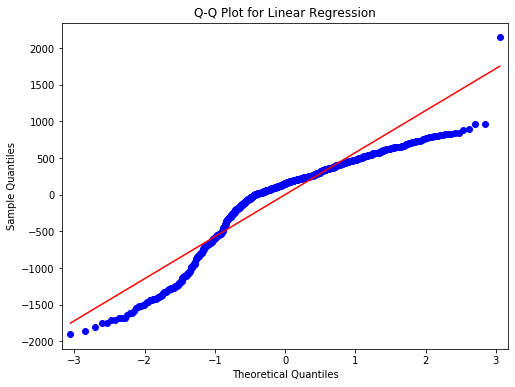

In [7]:
# lets start with the model we had from last week
# now perform linear regression using Ordinary Least Squares
# want to use all weather data from the BOM
X_bom = ['RainfallAmount_millimetres_',
         'DailyGlobalSolarExposure_MJ_m_m_',
         'MaximumTemperature_DegreeC_']
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'CyclistsInbound' in x]
# remove the response variable from here
X_bcc.remove('BicentennialBikewayCyclistsInbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables_linear = X_bom + X_bcc
Y_variable = 'BicentennialBikewayCyclistsInbound'

Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables_linear], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train_constant = sm.add_constant(X_train)
# also creating validation data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables_linear], dtype=np.float64)
X_val_constant = sm.add_constant(X_val)
# will create our test data as well, we will need it later on
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables_linear], dtype=np.float64)
# create the linear model
model = sm.OLS(Y_train, X_train_constant)
# fit the model without any regularisation
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val_constant)
pred_train = model_1_fit.predict(X_train_constant)
print('Linear Model Validation Data: RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, pred))))
print('Linear Model Training Data: RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_train, pred_train))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
# plt.show

Want to add some quadratic terms to our model.

MATLAB has a very easy x2fx function to help with these things, so we'll replicate that.

In [8]:
def x2fx(x, model='quadratic'):
  """Will create a quadratic, interaction and linear
  versions of our variable of interest

  Similar to the `x2fx()` function in Matlab.

  Written by Saullo G. P. Castro, from
  https://stackoverflow.com/questions/26574998/is-there-an-equivalent-function-for-x2fx-in-numpy

  Basically don't worry too much about how this func works. If I had to write it myself,
  it would look a lot worse than this.

  Args:
    x (np.array):
      Data set with columns as features (variables) that we 
      want to generate higher order terms for
    model (str):
      Determine linear, interaction, quadratic, purequadratic terms
 
  Returns:
    Array with higher order terms added as additional columns
  """
  from itertools import combinations as comb
  linear = np.c_[np.ones(x.shape[0]), x]
  if model == 'linear':
    return linear
  if model == 'purequadratic':
    return np.c_[linear, x**2]

  interaction = np.vstack([x[:,i]*x[:,j] for i, j in
                           comb(range(x.shape[1]), 2)]).T
  print(interaction.shape)
  if model == 'interaction':
    return np.c_[linear, interaction]
  if model == 'quadratic':
    return np.c_[linear, interaction, x**2]

Now we can convert all our data, and check the shape of the data to make sure it's as we expect.

In [9]:
print(X_train.shape)
print(X_test.shape)
X_train_complex = x2fx(X_train)
X_val_complex = x2fx(X_val)
X_test_complex = x2fx(X_test)
print(X_train_complex.shape)
print(X_val_complex.shape)

(888, 7)
(258, 7)
(888, 21)
(276, 21)
(258, 21)
(888, 36)
(276, 36)


Using our new data, we can now train another model - once again without any regularisation.

Model 2 Training Data: Quadratic Variables RMSE = 532.5166572108708
Model 2 Validation Data: Quadratic Variables RMSE = 788.1013862389883
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     29.20
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          2.72e-121
Time:                        18:59:32   Log-Likelihood:                -6834.5
No. Observations:                 888   AIC:                         1.374e+04
Df Residuals:                     852   BIC:                         1.391e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

Text(0.5, 1.0, 'Q-Q Plot for Model 2: Quadratic Variables')

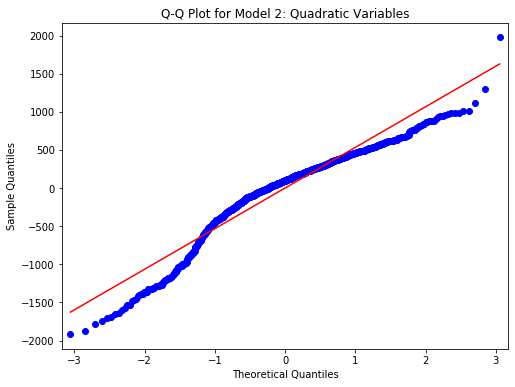

In [10]:
model = sm.OLS(Y_train, X_train_complex)
# fit the model without any regularisation
model_2_fit = model.fit()
pred_train = model_2_fit.predict(X_train_complex)
pred = model_2_fit.predict(X_val_complex)
print('Model 2 Training Data: Quadratic Variables RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Model 2 Validation Data: Quadratic Variables RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, pred))))
print(model_2_fit.summary())
print(model_2_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_2_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 2: Quadratic Variables')
# plt.show

Q-Q plot is deviating from the theoretical hytpothesis for the resdiduals, indicating that there is either a non-linear trend in our data, or there is non-constant variance (called heteroskedasticity) in our data (or there is both non-linear relationship and non-constant variance).
Plot tells us that one of our modelling assumptions is invalidated. Lets just have a look at the residuals themselves.

Text(0, 0.5, 'Residuals')

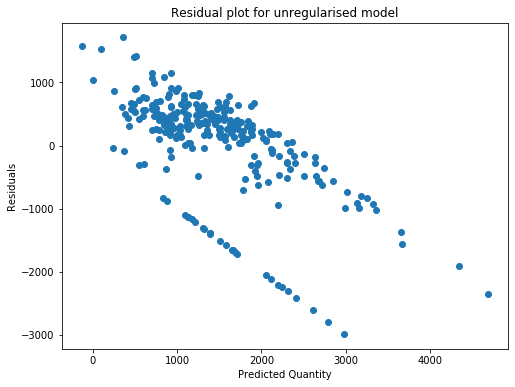

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(pred, Y_val - pred)
plt.title('Residual plot for unregularised model')
plt.xlabel('Predicted Quantity')
plt.ylabel('Residuals')
## plt.show

It is pretty clear from this plot that there are some significant outliers in our dataset, thus breaking the non-linearity assumption. The spread of the residuals is non-constant, which suggests heteroskedasticity. These two plots indicate that a lot of the assumptions made to make a linear regression model applicable are violated, thus we should treat predictions from such a model with trepedation.


The negative trend in this residuals plot could be partly due the the outliers seen (that strong line below). Lets just make a scatter plot of the predicted values and the true values to see these outliers.

Text(0, 0.5, 'True Quantity')

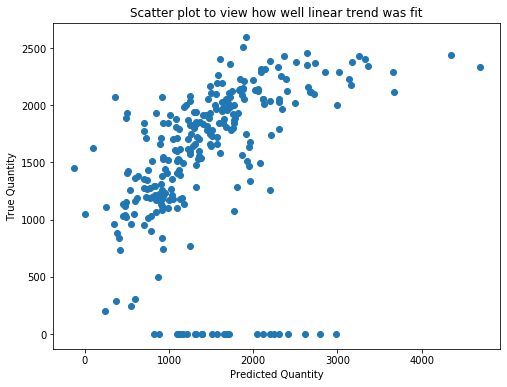

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(pred, Y_val)
plt.title('Scatter plot to view how well linear trend was fit')
plt.xlabel('Predicted Quantity')
plt.ylabel('True Quantity')
# plt.show

As expected, there are some serious outliers. To see if we can aleviate the affect of these values, we will move forward and apply some different regularisation techniques.

Before we go too far, we'll do a quick test with regularised regression. 

### Statsmodel vs SKLearn

In this solution we'll continue using the statsmodels package. In the lecture examples, we used sklearn - but both are valid approaches. The steps that we need to follow in both cases are the same too.

In [13]:
model_3 = sm.OLS(Y_train, X_train_complex)
model_3_fit = model_3.fit_regularized(alpha=10.0, L1_wt=1)
# to get L1 regression, need to set the L1_wt flag to 1 in the fit_regularzed method
pred = model_3_fit.predict(X_val_complex)
print('Model 3: L1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, pred))))
print(model_3_fit.params)

Model 3: L1 RMSE = 725.4697316462657
[ 3.94182938e+02  0.00000000e+00  1.74384051e+01  1.84100058e+00
  4.46973372e-01  1.25808317e+00  9.55461452e-01 -4.14282895e-01
  2.76948747e-01 -1.43409329e-01 -1.14273693e-01  1.28875130e-01
  3.91776884e-03 -2.16181137e-03 -4.61744523e-01 -5.51661200e-02
  3.32232782e-02  3.33075540e-02 -2.39384052e-02 -6.00604178e-02
  8.59374595e-02  1.22782199e-03  2.26033225e-02 -1.28604087e-02
 -2.23391473e-03  8.83632893e-03 -1.39827166e-03 -2.82630150e-03
  1.42272813e-03 -2.28598139e-02 -2.32409465e-01 -4.58893171e-01
  1.98144363e-03  1.64956967e-02  7.59354497e-04  7.84389353e-04]


### Note
For the regularised results, we need to get the residuals ourselves

Text(0.5, 1.0, 'Q-Q Plot for Model 3: Lasso')

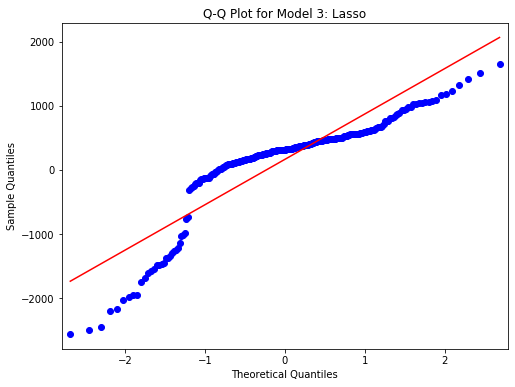

In [14]:
resid = Y_val - pred
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 3: Lasso')
# plt.show

Text(0, 0.5, 'Residuals')

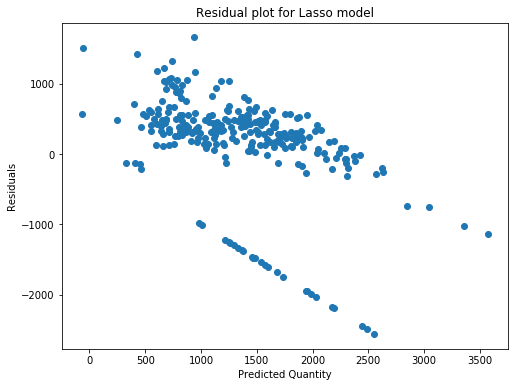

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(pred, resid)
plt.title('Residual plot for Lasso model')
plt.xlabel('Predicted Quantity')
plt.ylabel('Residuals')
# plt.show

We'll do a similar quick test for L2 (Ridge) regression.

Model 3: L2 RMSE = 788.5540106313709
[ 7.21266710e-02  2.90012152e-01  1.13455228e-01  6.77763123e-01
  2.97674506e+00  1.97236482e+00  3.22981415e+00  1.49399329e-01
  2.08574890e-01 -6.10285620e-02 -5.02158841e-02  7.21269471e-02
 -1.70052366e-03 -7.51115460e-03 -4.86624840e-01  4.18260444e-02
 -6.28896171e-01  5.32537546e-02 -5.37187471e-02 -5.49143031e-01
  2.65715923e-01 -4.71950143e-02  5.15406089e-02  5.66379958e-02
 -8.28974929e-03  6.94487806e-03 -1.78787990e-02 -1.80805196e-02
  3.11510171e-03 -2.53393057e-02  1.56011731e+00  1.23245265e-01
  2.07365756e-02  7.19955494e-02  1.57289297e-03  1.58001579e-03]


Text(0.5, 1.0, 'Q-Q Plot for Model 3: Lasso')

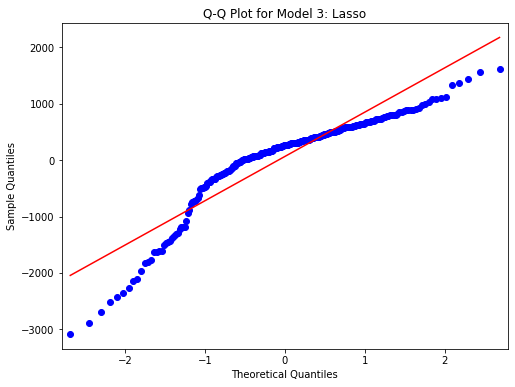

In [16]:
# L2 Regression
model_3_fit = model_3.fit_regularized(alpha=100.0, L1_wt=0)
# to get L1 regression, need to set the L1_wt flag to 1 in the fit_regularzed method
pred = model_3_fit.predict(X_val_complex)
resid = Y_val - pred
print('Model 3: L2 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, pred))))
print(model_3_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 3: Lasso')
# plt.show

Text(0, 0.5, 'Residuals')

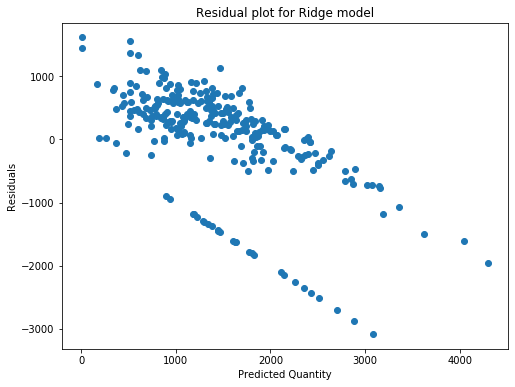

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(pred, resid)
plt.title('Residual plot for Ridge model')
plt.xlabel('Predicted Quantity')
plt.ylabel('Residuals')
# plt.show

Looking at these plots, it we can see that we didn't actually gain anything by going to more complicated feature set using the `x2fx()` function, nonetheless, we'll continue with both models and see how we go.

## Standardise data set

As we've noted previously, standardising the data can make a big difference in terms of performance and ease of visualisation. As such we'll do that hre.

Note that we'll compute the mean and std.dev on the training data, and then use those to standardise the validation and testing sets as well. We don't want to compute the mean and std.dev on each set independantly, as it will mean that each set gets standardised in a slightly different way.

In [18]:
def standardise(data):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  mu = np.mean(data, axis=0)
  sigma = np.std(data, axis=0)
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

In [19]:
X_train_std, mu_train_x, sigma_train_x = standardise(X_train)
Y_train_std, mu_train_y, sigma_train_y = standardise(Y_train)
X_val_std = (X_val - mu_train_x)/sigma_train_x
Y_val_std = (Y_val - mu_train_y)/sigma_train_y
X_test_std = (X_test - mu_train_x)/sigma_train_x
Y_test_std = (Y_test - mu_train_y)/sigma_train_y
print(mu_train_x)

# remove constant term - this is not needed with standardised data, and as a constant has a std.dev of 
# 0 will result is numeric issues if we leave it in
X_train_complex = np.delete(X_train_complex, 0, 1)
X_val_complex = np.delete(X_val_complex, 0, 1)
X_test_complex = np.delete(X_test_complex, 0, 1)
X_train_complex_std, mu_train_complex_x, sigma_train_complex_x = standardise(X_train_complex)
X_val_complex_std = (X_val_complex - mu_train_complex_x)/sigma_train_complex_x
X_test_complex_std = (X_test_complex - mu_train_complex_x)/sigma_train_complex_x

[  2.83423423  18.14481982  26.57398649 106.6722973   83.24887387
 290.67792793 336.83220721]


## Question 2: Ridge Regression

Apply ridge regression to your two models (the simple model from Week 1, and the overfitting model from Problem 1 of this week). Using the validation set, select the best value of λ for each model. For the selected model:
* Compute the R2 and adjusted R2, and draw a qqplot to assess the models validity;
* Compute the RMSE on the test set and compare the performance with the linear models.

### Evaluate Ridge Regression

To make life easy, we'll wrap this up in a function. This will take our data (and standardising parameters) and set of $\lambda$'s to use.

In [20]:
def rmse(actual, pred):
  return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
  r2 = r2_score(actual, predicted)
  return r2

def adj_r2(actual, predicted, n, p):
  r2 = r2_score(actual, predicted)
  adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
  return adjr2

def evaluate_regularisation(x_train, y_train, x_val, y_val, x_test, y_test,
                            response_mu, response_sigma, alpha_list, L1_L2):
  """
  Evaluates the efficacy of regularisation for a linear model.
  
  Identifies which values regression coffections and values of alpha
  (the hyperparam for the strength of regularisation) offers the
  best performance on the validation set.

  Evaluation is required to be performed on the standardised data, to allow
  for ease of comparison (where standardised here refers to normalisation,
  such that the data has a mean of zero and a std. of one.) This will show
  
  Will display the coefficients used in the NORMALISED/STANDARDISED model 
  used to achieve the best results.

  Is able to evaluate both Ridge and Lasso regularisation (and Elasticnet
  really if you want to try it, but in this class we are sticking to Ridge
  and Lasso).

  Args:
    x_train (np.array):
      normalised predictor variable training data
    y_train (np.array):
      normalised response variable training data
    x_val (np.array):
      normalised predictor variable validation data
    y_val (np.array):
      normalised response variable validation data
    x_test (np.array):
      normalised predictor variable test data
    y_test (np.array):
      normalised response variable test data
    response_mu (np.array):
      the mean value of the response variable from the TRAINING data
    response_sigma (np.array):
      the standard deviation  of the response variable from the TRAINING data
    alpha_list (list[np.float]):
      proposed values for alpha (the regularisation hyper param, also called
      lambda in other texts and in the lectures). Each value must be greater
      than zero.
    L1_L2 (np.int):
      Boolean to say whether we want to perform Ridge or Lasso regularisation.
      When zero, will be Ridge, When one, will be Lasso.
      Note: this value can actually be a float between zero and one as well 
      if you want to try Elasticnet regression, but here in this class would
      recommend sticking to just Ridge and Lasso.

  Retuns:
    NA
  """
  # Ridge: L1_L2 = 0
  # Lasso: L1_L2 = 1
  # create the model
  model = sm.OLS(y_train, x_train)
  # initialise the value for best RMSE that is obnoxiously large, as we want this be 
  # overwritten each time RMSE is smaller, since smaller is better and we want to 
  # update our best models each time the RMSE is smaller.
  best_rmse = 10e12
  best_alpha = []
  rmse_val = []
  rmse_train = []
  best_coeffs = []
  for alpha in alpha_list:
    model_cross_fit = model.fit_regularized(alpha=alpha, L1_wt=L1_L2)
    train_pred = model_cross_fit.predict(x_train)
    val_pred = model_cross_fit.predict(x_val)
    # want to append the rmse value to a list, as will plot all values later on
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, val_pred)))
    # if this is the model with the lowest RMSE, lets save it
    # the [-1] index says get the last value from the list (which is the most recent RMSE)
    if rmse_val[-1] < best_rmse:
      best_rmse = rmse_val[-1]
      best_alpha = alpha
      best_coeffs = model_cross_fit.params
      
  print('Best values on Validation Data set')
  # extract the gradient and the bias from the coefficients
  # The reshape will make sure the slope is a column vector
  slope = np.array(best_coeffs[0:]).reshape(-1, 1)
  # the intercept coefficient is the last index variable, which was included with the
  # sm.add_constant() method
  # use the @ operator to perform vector/matrix multiplication
  pred_val_rescaled = (x_val @ slope) * response_sigma + response_mu
  pred_train_rescaled = (x_train @ slope) * response_sigma + response_mu
  best_r2 = r_squared(y_train * response_sigma + response_mu, pred_train_rescaled)
  best_adj_r2 = adj_r2(y_train * response_sigma + response_mu, pred_train_rescaled,
                           x_train.shape[0], x_train.shape[1]) 
  best_val_rmse = np.sqrt(mean_squared_error(y_val* response_sigma + response_mu, pred_val_rescaled))
  print('Best R Squared = {}'.format(best_r2))
  print('Best Adjusted = {}'.format(best_adj_r2))
  print('Best RMSE (val) = {}'.format(best_val_rmse))
  print('Best coefficients on the normalised model')
  print('Best slope = {}'.format(slope))
  
  # now plotting some data
  fig, axs = plt.subplots(4, figsize=(20, 25))
  # plot the first values of alpha vs RMSE for train and validation data    
  axs[0].plot(np.array(alpha_list), rmse_train)
  axs[0].plot(np.array(alpha_list), rmse_val)
  axs[0].legend(['Training', 'Validation'])
  axs[0].set_title('RMSE vs Lambda')
  axs[0].set_xlabel('Lambda')
  axs[0].set_ylabel('RMSE')    
  # plot prediction and true values for test set
  axs[1].plot((y_test*response_sigma + response_mu))
  axs[1].plot((x_test @ slope) * response_sigma + response_mu)
  axs[1].legend(['Actual', 'Predicted'])
  axs[1].set_title('Test Set Performance')
  # plotting the Q-Q plot
  train_pred = (x_train @ slope).reshape(y_train.shape)
  resid = y_train - train_pred
  sm.qqplot(resid, ax=axs[2], line='s')
  axs[2].set_title('Q-Q Plot for Linear Regression')
  # plot the residuals as well
  axs[3].scatter(train_pred, resid)
  axs[3].set_title('Residuals for training set')
  axs[3].set_xlabel('Predicted')
  axs[3].set_ylabel('Residuals')

### Simple Data 

Best values on Validation Data set
Best R Squared = 0.46873922281710556
Best Adjusted = 0.4645132848167871
Best RMSE (val) = 619.3865350206288
Best coefficients on the normalised model
Best slope = [[-0.03560322]
 [-0.054623  ]
 [-0.14413278]
 [ 0.03407108]
 [ 0.17868791]
 [ 0.5315596 ]
 [ 0.29919274]]


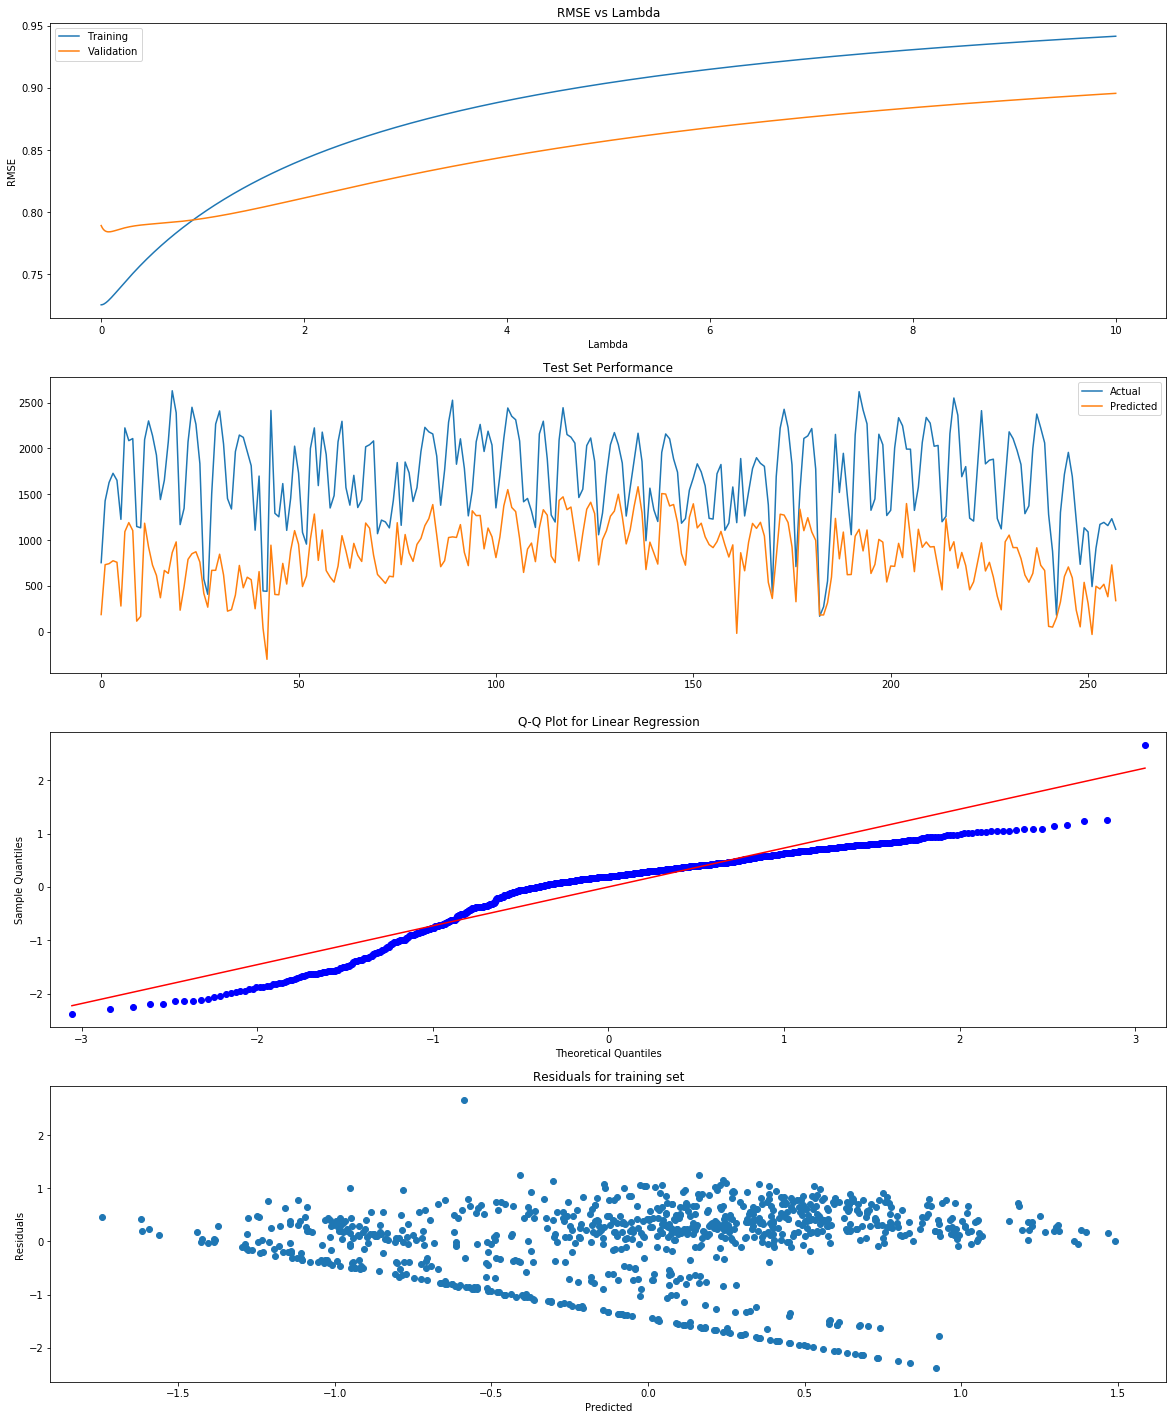

In [21]:
alpha_list = np.linspace(0, 10.0, 1000)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 0)

### Complex Data

Best values on Validation Data set
Best R Squared = 0.37946205997861304
Best Adjusted = 0.35397047793548087
Best RMSE (val) = 616.1508392783029
Best coefficients on the normalised model
Best slope = [[-0.01103779]
 [-0.01113235]
 [-0.02070855]
 [ 0.02472786]
 [ 0.02692352]
 [ 0.05352315]
 [ 0.02353047]
 [-0.00619847]
 [-0.01225968]
 [-0.00709231]
 [-0.00432444]
 [ 0.00567832]
 [-0.00756287]
 [-0.0144222 ]
 [ 0.01048475]
 [ 0.00396515]
 [ 0.04486093]
 [ 0.01039225]
 [ 0.01556417]
 [ 0.01320565]
 [ 0.04922568]
 [ 0.0190386 ]
 [ 0.02692221]
 [ 0.03947364]
 [ 0.03171448]
 [ 0.05098593]
 [ 0.0289696 ]
 [ 0.04562899]
 [-0.00584601]
 [-0.0117038 ]
 [-0.01970011]
 [ 0.02340377]
 [ 0.02661721]
 [ 0.04390074]
 [ 0.02362364]]


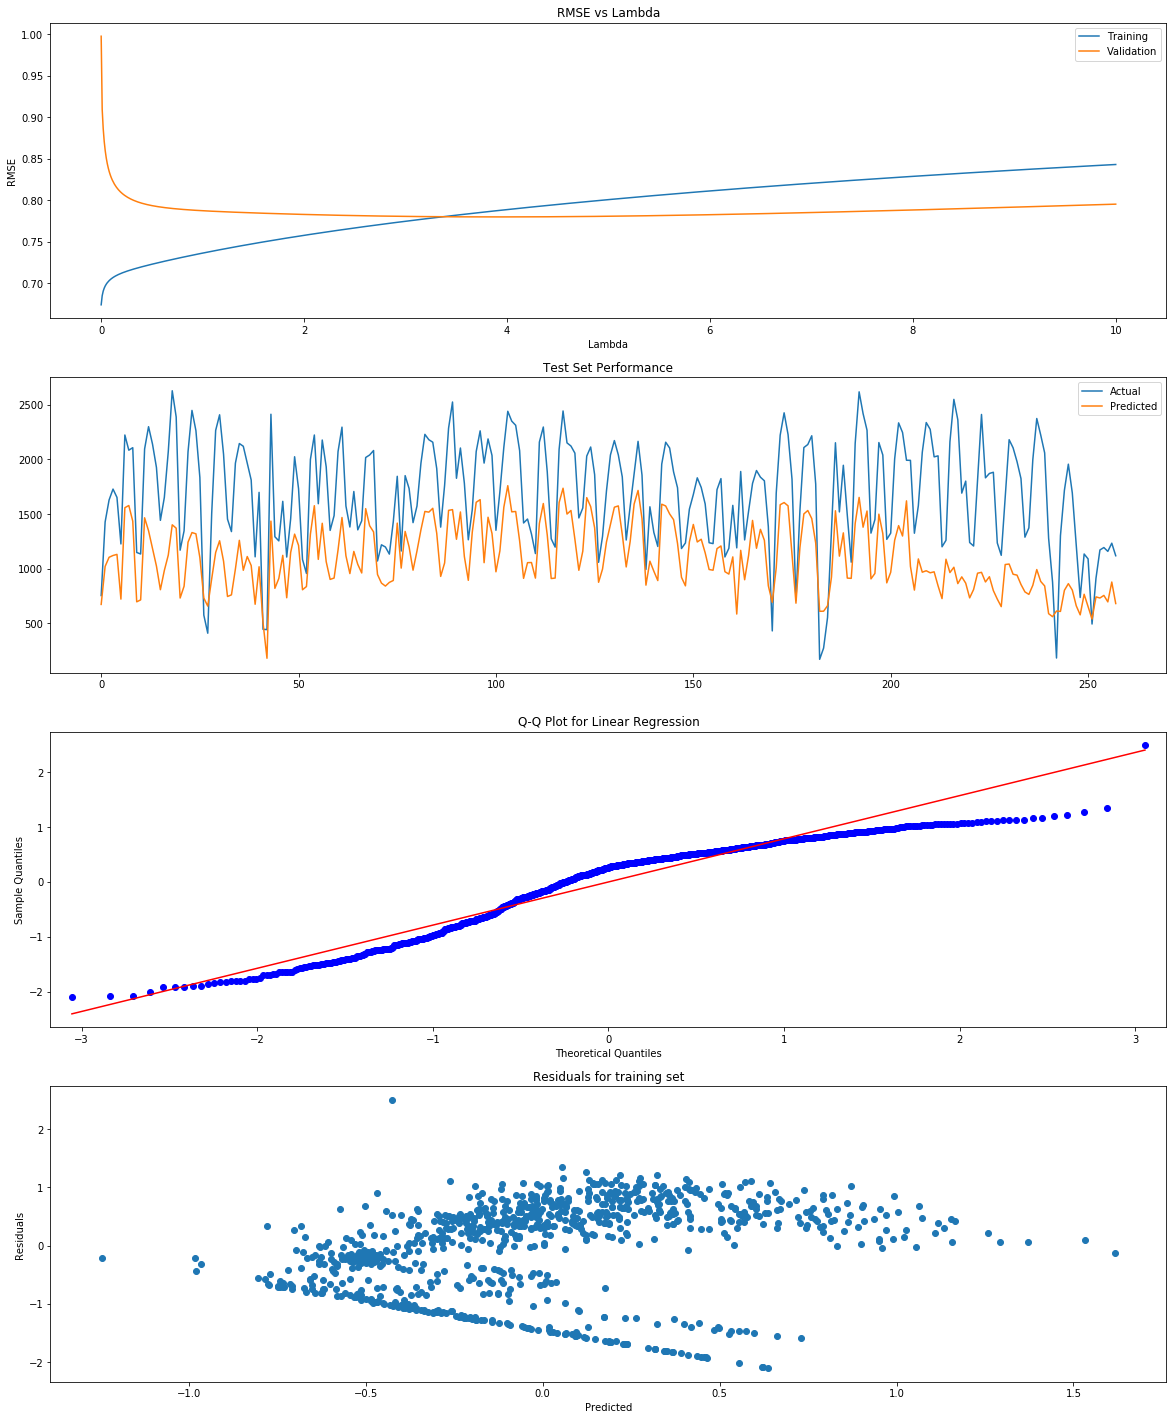

In [22]:
alpha_list = np.linspace(0, 10.0, 1000)
evaluate_regularisation(X_train_complex_std, Y_train_std, X_val_complex_std, Y_val_std, X_test_complex_std, 
                        Y_test_std, mu_train_y, sigma_train_y, alpha_list, 0)

## Question 3: Lasso Regression

Apply lasso regression to your two models (the simple model from Week 1, and the overfitting model from Problem 1 of this week). Using the validation set, select the best value of λ for each model. For the selected model:
* Compute the R2 and adjusted R2 (make sure to consider how many terms are removed by lasso), and draw a qqplot to assess the models validity;
* Compute the RMSE on the test set and compare the performance with the linear models and the ridge regression models.

### Evaluate Lasso Regression

As per ridge regression, we'll use our above function to do this. Because of the way that we set this function up, and the way statsmodels regularised regression is done we just need to change a value that controls the influence of the L1 and L2 terms.

### Simple Data

Best values on Validation Data set
Best R Squared = 0.41036644799716604
Best Adjusted = 0.4056761811062344
Best RMSE (val) = 591.8438646852854
Best coefficients on the normalised model
Best slope = [[ 0.        ]
 [ 0.        ]
 [-0.00156341]
 [ 0.00201804]
 [ 0.0726036 ]
 [ 0.46948568]
 [ 0.20837985]]


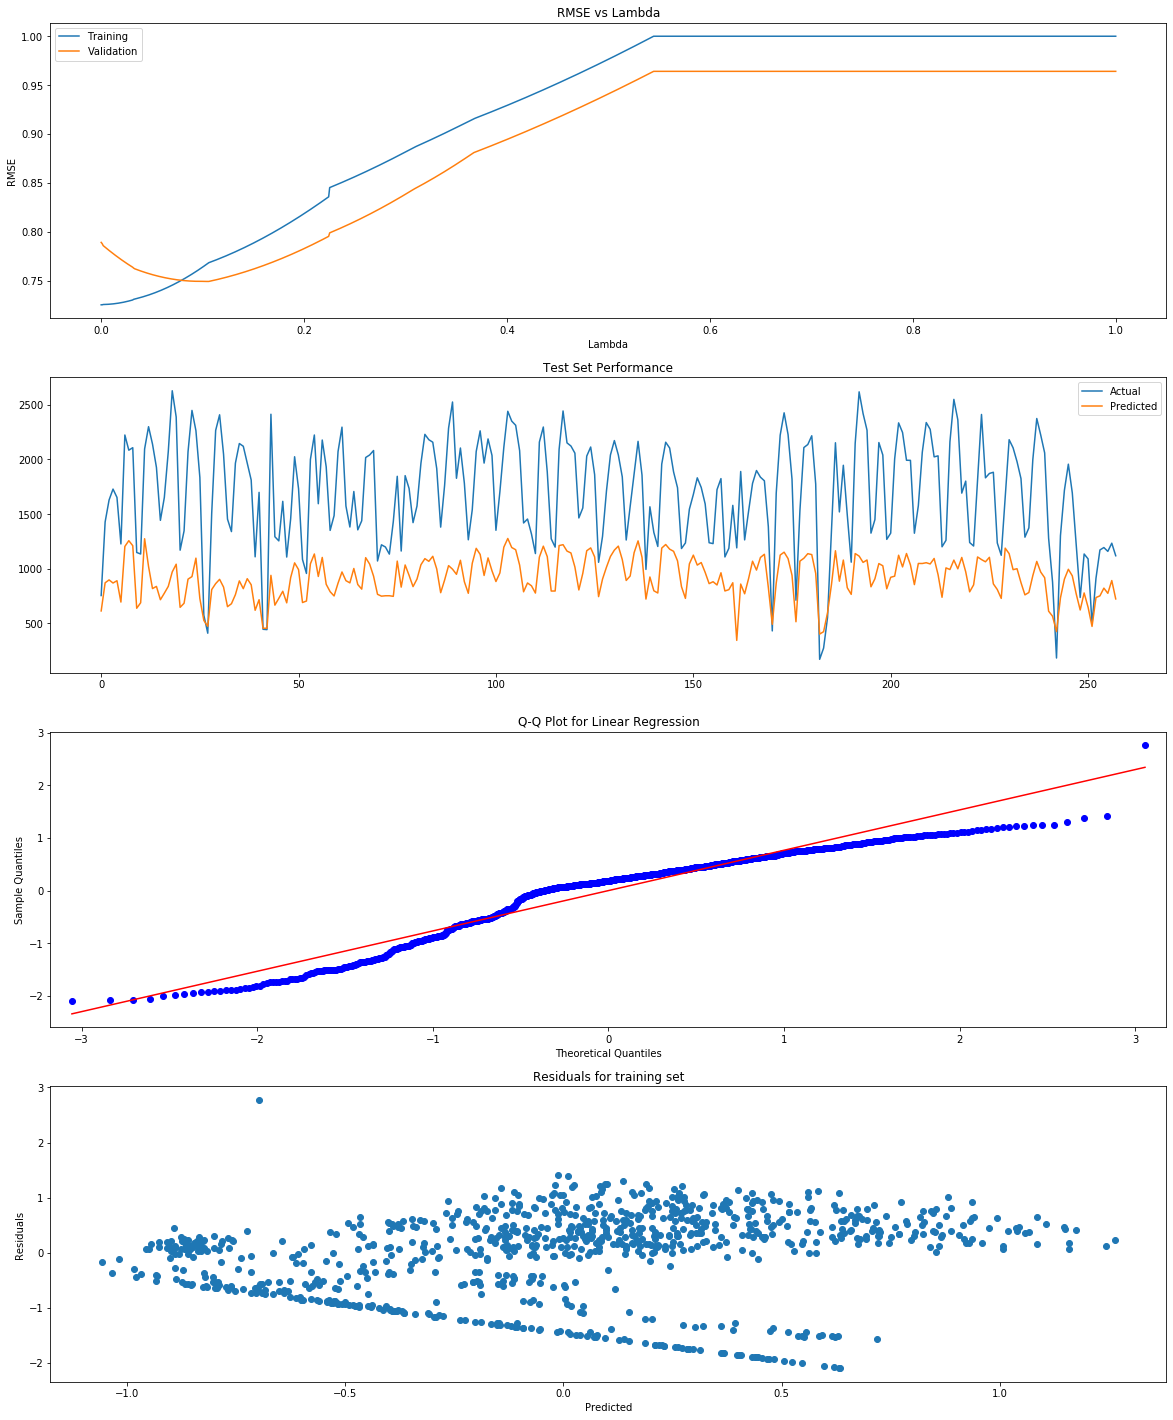

In [23]:
alpha_list = np.linspace(0, 1.0, 1000)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 1)

### Complex Data

Best values on Validation Data set
Best R Squared = 0.4412797294278261
Best Adjusted = 0.41832760563671567
Best RMSE (val) = 592.8510638980653
Best coefficients on the normalised model
Best slope = [[ 0.        ]
 [ 0.        ]
 [-0.04004744]
 [ 0.        ]
 [ 0.        ]
 [ 0.32572088]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.14300743]
 [ 0.18614673]
 [ 0.07751691]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.06619235]]


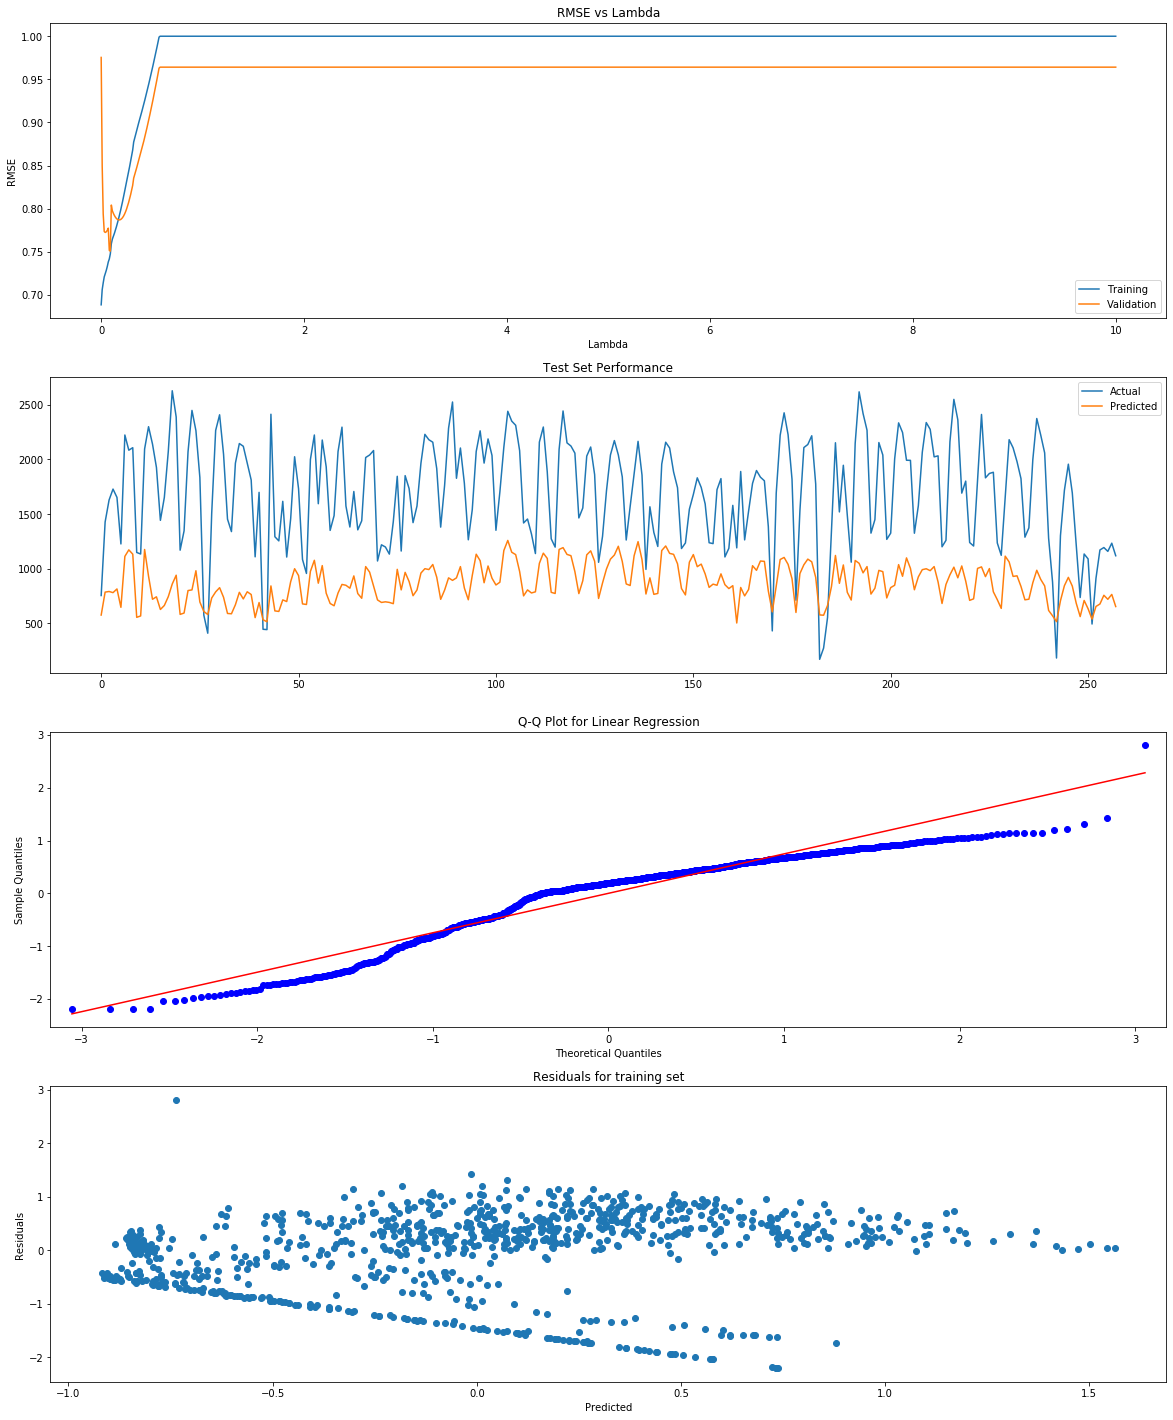

In [24]:
alpha_list = np.linspace(0, 10.0, 1000)
evaluate_regularisation(X_train_complex_std, Y_train_std, X_val_complex_std, Y_val_std, X_test_complex_std, 
                        Y_test_std, mu_train_y, sigma_train_y, alpha_list, 1)

# Overall Performace
Our best performance on the validation set, and thus the model we'd likely select if this was a real life situation, is the simple lasso model, which has an RMSE that dips under 600. Even for the simple model with very few terms, we get an improvement by being able to penalise large weights

Considering our more complex models, regularisation helps these compared to their linear counterparts, but we don't necessarily get better performace by adding more terms.


# For you to do
Compute the RMSE for the Test set using the best model found. Could add it to the `evaluate_regularisation` function.

Could also try and apply the regularisation to the models using the complex terms `x2fx` to try and find optimal parameters. Note that you wont need to use the `sm.add_constant()` method, as the `x2fx()` function will add the constant term for you.